<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Extract-true-and-false-positive-rates" data-toc-modified-id="Extract-true-and-false-positive-rates-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extract true and false positive rates</a></span></li><li><span><a href="#Prediction-of-unperturbed-nodes-with-prior-network-knowledge" data-toc-modified-id="Prediction-of-unperturbed-nodes-with-prior-network-knowledge-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prediction of unperturbed nodes with prior network knowledge</a></span></li><li><span><a href="#Correlation-between-true-and-fitted-parameters-with-prior-network-knowledge" data-toc-modified-id="Correlation-between-true-and-fitted-parameters-with-prior-network-knowledge-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Correlation between true and fitted parameters with prior network knowledge</a></span></li></ul></div>

# Summary

Here we extract information from CNR reconstructions based on an incomplete number of perturbations of data simulated from the Orton model.
The obtained information is exported, plots are prepared in R.

**Overview of the data:**

  * We performed CNR using reduced input data by randomly selecting between 2 to 10 out of 12 perturbation.
  * For each reconstruction, a fixed eta and theta were used.
  * 10 % noise was added to the original global response matrix for each reconstruction.
  * The same perturbations and niosy global response matrices were used for each panel to ensure fair comparison.
  * This procedure 50 times for each number of different perturbations.
 
Comparative network reconstruction was performed on multiple panels:

  * WT + BRAF mutant 
  * WT + RAS mutant 
  * WT + EGFR mutant 
  * All combined 
  * All single

Theta was set to 0.01 for each panel.

The reconstructions were run using the script "scripts/CNR-npert-correlation.py". The results were stored as pickle objects in the paths:"results/solutions/sols_npert_correlation.pickle".

Results are stored in a dict with structure.
  * Panel name
    * Repetition
      * list of solution for different values of eta.
      * list of dictionaries with the global response matrices used.

The whole procedure was repeated for CnrProblems restrained to a prior network and with eta=0 with correct interaction to test the ability to quantify a known network based on few perturbations.

In [1]:
import os
import sys

import random
import pickle
import cnr
import numpy as np
import pandas as pd
import seaborn as sns
from mypyutils import utils
import matplotlib.pyplot as plt
import scipy.stats.stats 
from mypyutils.utils import flatten_list

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
with open("results/solutions/sols_npert_correlations.pickle", "rb") as handle:
    sols = pickle.load(handle)
    
with open("results/solutions/sols_npert_correlations-priornetwork.pickle", "rb") as handle:
    sols_prior = pickle.load(handle)
    
REF_IMAP = pd.read_csv("results/simulations/imap.tsv", sep='\t', index_col=0)

rglobs = sols.pop("rglob_full")
rglobs_prior = sols_prior.pop("rglob_full")

In [6]:
# Local response matrices
fSimResults_rloc = 'results/simulations/ortonModel-knockdown-mutWT-rloc.tsv'
fSimResults_mutRAS_rloc = 'results/simulations/ortonModel-knockdown-mutRAS-rloc.tsv'
fSimResults_mutBRAF_rloc = 'results/simulations/ortonModel-knockdown-mutBRAF-rloc.tsv'
fSimResults_mutEGFR_rloc = 'results/simulations/ortonModel-knockdown-mutEGFR-rloc.tsv'

rloc_wt   = pd.read_csv(fSimResults_rloc, sep='\t', index_col=0)
rloc_ras  = pd.read_csv(fSimResults_mutRAS_rloc, sep='\t', index_col=0)
rloc_braf = pd.read_csv(fSimResults_mutBRAF_rloc, sep='\t', index_col=0)
rloc_egfr = pd.read_csv(fSimResults_mutEGFR_rloc, sep='\t', index_col=0)

true_rloc_dict = {"wt": rloc_wt, "ras": rloc_ras, "braf": rloc_braf, "egfr": rloc_egfr }

# Perturbation matrices
fSimResults_rpert = 'results/simulations/ortonModel-knockdown-mutWT-rpert.tsv'
fSimResults_mutRAS_rpert = 'results/simulations/ortonModel-knockdown-mutRAS-rpert.tsv'
fSimResults_mutBRAF_rpert = 'results/simulations/ortonModel-knockdown-mutBRAF-rpert.tsv'
fSimResults_mutEGFR_rpert = 'results/simulations/ortonModel-knockdown-mutEGFR-rpert.tsv'

rpert_wt   = pd.read_csv(fSimResults_rpert, sep='\t', index_col=0)
rpert_ras  = pd.read_csv(fSimResults_mutRAS_rpert, sep='\t', index_col=0)
rpert_braf = pd.read_csv(fSimResults_mutBRAF_rpert, sep='\t', index_col=0)
rpert_egfr = pd.read_csv(fSimResults_mutEGFR_rpert, sep='\t', index_col=0)

true_rpert_dict = {"wt": rpert_wt, "ras": rpert_ras, "braf": rpert_braf, "egfr": rpert_egfr}

In [7]:
def tpr(imap, ref_imap):
    tp = ((imap == 1) & (ref_imap == 1)).sum().sum()
    p = ref_imap.sum().sum()
    return(tp/p)

def fpr(imap, ref_imap):
    fp = ((imap == 1) & (ref_imap == 0)).sum().sum()
    n = (ref_imap == 0).sum().sum() - REF_IMAP.shape[0] # Subtract diagonal from # of negatives
    return(fp/n)


# Extract true and false positive rates 

In [8]:
df = pd.DataFrame(columns = ["cl", "NPERT", "tpr", "fpr"])
for cl, s_dict in sols.items():
    for npert, s_lst, in s_dict.items():
        for s in s_lst:
            if s is not None:
                ser = pd.Series([cl, npert, tpr(s.imap, REF_IMAP), fpr(s.imap, REF_IMAP)],
                               index = ["cl", "NPERT", "tpr", "fpr"])
                df = df.append(ser, ignore_index=True)
df.to_csv("results/solutions/npert-tpr-fpr.tsv", sep="\t", index=False)

These data are written to file and used as input for a R plotting script

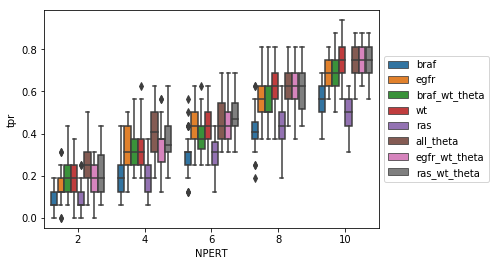

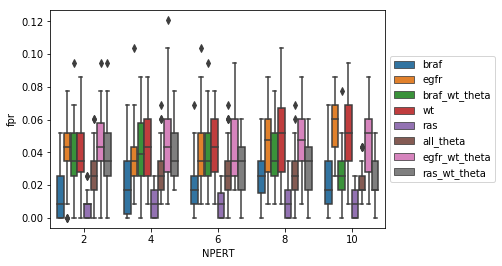

In [9]:
sns.boxplot(data = df, x = "NPERT", y = "tpr", hue="cl")
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.show()
sns.boxplot(data = df, x = "NPERT", y = "fpr", hue="cl")
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.show()

# Prediction of unperturbed nodes with prior network knowledge

In [12]:
def get_correlations(sol, rglob_dict, pert_annot):   
    prediction_dict = get_prediction(sol, ALL_PERTS)
    cl_lst = []
    perturbed_node_lst = []
    pearsonr_lst = []
    pval_pearson = []
    spearmanr_lst = []
    pval_spearman = []

    if prediction_dict is not None:
        for cl, predictions in prediction_dict.items():
            for perturbation, predicted_response in predictions.iteritems():
                perturbed_node = pert_annot[perturbation]

                prediction_use = (predicted_response.drop(perturbed_node).tolist())
                rglob_use = (rglob_dict[cl][perturbation].drop(perturbed_node).tolist())
                # Discard perturbations that have no effect
                if (sum(map(abs, rglob_use)) > 1e-12) & (sum(map(abs, prediction_use)) >1e-12):
                    pearson = scipy.stats.pearsonr(prediction_use, rglob_use)
                    spearman = scipy.stats.spearmanr(prediction_use, rglob_use)
                    cl_lst.append(cl)
                    perturbed_node_lst.append(perturbed_node)
                    pearsonr_lst.append(pearson[0])
                    pval_pearson.append(pearson[1])
                    spearmanr_lst.append(spearman[0])
                    pval_spearman.append(spearman[1])

    df = pd.DataFrame(
        {"cl": cl_lst,
         "perturbed_node": perturbed_node_lst,
         "pearsonr": pearsonr_lst,
         "pval_pearson": pval_pearson,
         "spearmanr": spearmanr_lst,
         "pval_spearman": pval_spearman
        }
    )
    return df

In [14]:
df_lst = []
for panel, s_dict in sols_prior.items():
    for npert, s_lst in s_dict.items():
        for rep, s in enumerate(s_lst):
            if s is not None:
                df = get_correlations(s, rglobs_prior[npert][rep], PERT_ANNOT)
                df["NPERT"] = npert
                df["PANEL"] = panel
                df["REP"] = rep
                df_lst.append(df)

In [15]:
df = pd.concat(df_lst, ignore_index=True)

In [16]:
df.to_csv("results/solutions/npert-correlations-priornetwork.tsv", sep="\t", index=False)

# Correlation between true and fitted parameters with prior network knowledge

In [ ]:
def get_correlations_param(sol, trp_dict, trl_dict):  

    cl_lst = []
    pearsonr_lst = []
    pval_pearson = []
    spearmanr_lst = []
    pval_spearman = []

    for cl in sol.cell_lines:
        if sol.rglob[cl].abs().sum().sum() > 1e-12:
        
            # Select non-zero reconstructed parameters (rloc and rpert)
            rp = np.array(sol.rpert[cl])
            rl = np.array(sol.rloc[cl]) + np.identity(12)
            nz_pert = np.nonzero(rp)
            nz_rloc = np.nonzero(rl)

            # Select the corresponding true parameters (rpert and rloc)
            trp = np.array(trp_dict[cl][sol.rpert[cl].columns])
            trl = np.array(trl_dict[cl])

            # Get correlations between reconstructed and true parameters
            pearson = scipy.stats.pearsonr(
                np.concatenate((rp[nz_pert],  rl[nz_rloc])),
                np.concatenate((trp[nz_pert], trl[nz_rloc]))
            )
            spearman = scipy.stats.spearmanr(
                np.concatenate((rp[nz_pert],  rl[nz_rloc])),
                np.concatenate((trp[nz_pert], trl[nz_rloc]))
            )

            # Store results in list (temporary)
            cl_lst.append(cl)
            pearsonr_lst.append(pearson[0])
            pval_pearson.append(pearson[1])
            spearmanr_lst.append(spearman[0])
            pval_spearman.append(spearman[1])
    
    # Combine results in a dataframe
    df = pd.DataFrame(
        {"cl": cl_lst, 
         "pearsonr": pearsonr_lst,
         "pval_pearson": pval_pearson,
         "spearmanr": spearmanr_lst,
         "pval_spearman": pval_spearman
        }
    )
    return df

In [ ]:
df_lst = []
for panel, s_dict in sols_prior.items():
    for npert, s_lst in s_dict.items():
        for rep, s in enumerate(s_lst):
            if s is not None:
                df = get_correlations_param(s, true_rpert_dict, true_rloc_dict)
                df["NPERT"] = npert
                df["PANEL"] = panel
                df["REP"] = rep
                df_lst.append(df)

In [ ]:
df = pd.concat(df_lst, ignore_index=True)

In [ ]:
df.to_csv("../results/solutions/npert-correlations-param-priornetwork.tsv", sep="\t", index=False)